In [1]:
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient
        
        
def define_panels(x, y, N):
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels


class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.cos(panel_i.beta),numpy.sin(panel_i.beta))
    return A


def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A


def kutta_condition(A_source, B_vortex):
    b = numpy.empty([2,A_source.shape[1]+2],dtype=float)
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])
    
    return b


def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A


def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b


def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

        
def compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels],gamma_m)
    strengths = numpy.append(strengths,gamma_f)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2
        


In [109]:
def rotation(point,theta,x,y):
    theta1=theta/180*numpy.pi
    x_1,y_1=0,0
    x_1=x-point[0]*numpy.ones_like(x)
    y_1=y-point[1]*numpy.ones_like(y)
    x_r=x_1*numpy.cos(theta1)+y_1*numpy.sin(theta1)+point[0]*numpy.ones_like(x)
    y_r=x_1*(-1)*numpy.sin(theta1)+y_1*numpy.cos(theta1)+point[1]*numpy.ones_like(y)
    return x_r,y_r

In [4]:
x_m, y_m=numpy.loadtxt("resources/NACA23012_MainFoil.csv",dtype=float,delimiter=',',unpack=True)
x_f,y_f=numpy.loadtxt("resources/NACA23012_FlapFoil.csv",dtype=float,delimiter=',',unpack=True)
theta=20
point=[1.03,-0.054]
x_f,y_f=rotation(point,theta,x_f,y_f)

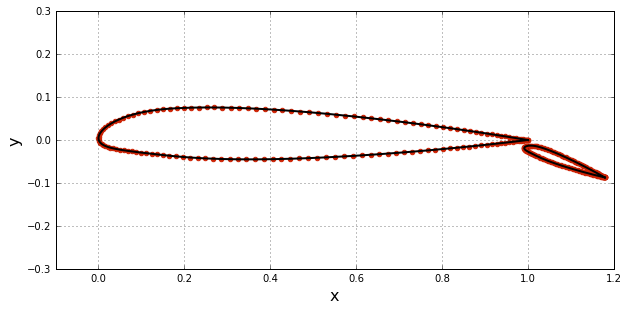

In [5]:
N,u_inf,alpha=len(x_m)-1,1,0
panels_m = define_panels(x_m, y_m, N)
panels_f = define_panels(x_f, y_f, N)

# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_m, y_m,x_f,y_f,color='k', linestyle='-', linewidth=2)
pyplot.scatter([panel.xa for panel in panels_m],[panel.ya for panel in panels_m],color='#CD2305')
pyplot.scatter([panel.xa for panel in panels_f],[panel.ya for panel in panels_f],color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.2)
pyplot.ylim(-0.3, 0.3);

In [6]:
panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels_m[i]
    elif i>=N:
        panels[i]=panels_f[i-N]

A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)

In [7]:
alpha_1,alpha_2,alpha=-14,14,0
erro=1
while erro>0.0001:
    alpha=(alpha_1+alpha_2)/2
    Lift,Lift_1=0,0
    freestream = Freestream(u_inf,alpha_1)
    b = build_freestream_rhs(panels,freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma_m= strengths[-2]
    gamma_f = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        Lift_1 -=panel.cp*numpy.sin(panel.beta)*panel.length

    #lift_assume
    freestream = Freestream(u_inf,alpha)
    b = build_freestream_rhs(panels,freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma_m = strengths[-2]
    gamma_f = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        Lift -=panel.cp*numpy.sin(panel.beta)*panel.length
    
    if Lift_1*Lift<0:
        alpha_2=alpha
    elif Lift_1*Lift>0:
        alpha_1=alpha
    erro=abs(Lift)
    

In [8]:
alpha

-10.963134765625

In [143]:
#Q2
x_m, y_m=numpy.loadtxt("resources/NACA23012_MainFoil.csv",dtype=float,delimiter=',',unpack=True)
x_f,y_f=numpy.loadtxt("resources/NACA23012_FlapFoil.csv",dtype=float,delimiter=',',unpack=True)
panels_m = define_panels(x_m, y_m, N)
point=[1.03,-0.054]
N,u_inf,alpha=len(x_m)-1,1,0
theta1,theta2,theta=-5,0,0
erro=1
freestream = Freestream(u_inf,alpha)

In [144]:
while erro>0.001:
    lift1,lift=0,0
    theta=(theta1+theta2)/2
    x_f_n,y_f_n=rotation(point,theta1,x_f,y_f)
    panels_f = define_panels(x_f_n, y_f_n, N)
    panels=numpy.empty(N*2, dtype=object)
    for i in range(N*2):
        if i<N:
            panels[i]=panels_m[i]
        elif i>=N:
            panels[i]=panels_f[i-N]
    A_source=source_contribution_normal(panels)
    B_vortex= vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels,freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma_m = strengths[-2]
    gamma_f = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        lift1 -=panel.cp*numpy.sin(panel.beta)*panel.length

    x_f_n,y_f_n=rotation(point,theta,x_f,y_f)
    panels_f = define_panels(x_f_n, y_f_n, N)
    panels=numpy.empty(N*2, dtype=object)
    for i in range(N*2):
        if i<N:
            panels[i]=panels_m[i]
        elif i>=N:
            panels[i]=panels_f[i-N]
    A_source=source_contribution_normal(panels)
    B_vortex= vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels,freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma_m = strengths[-2]
    gamma_f = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        lift -=panel.cp*numpy.sin(panel.beta)*panel.length
        
    if lift1*lift<0:
        theta2=theta
    elif lift1*lift>0:
        theta1=theta
    erro=abs(lift)

In [145]:
theta

-4.51171875

In [117]:
#Q3
x_m, y_m=numpy.loadtxt("resources/NACA23012_MainFoil.csv",dtype=float,delimiter=',',unpack=True)
x_f,y_f=numpy.loadtxt("resources/NACA23012_FlapFoil.csv",dtype=float,delimiter=',',unpack=True)
x_f_n,y_f_n=0,0
point=[1.03,-0.054]
Lift,Drag=0.,0.
N,u_inf,alpha=len(x_m)-1,1.,4.
theta_all=numpy.array([0.,5.,10.,15.])
lift,drag=numpy.zeros_like(theta_all),numpy.zeros_like(theta_all)
freestream = Freestream(u_inf,alpha)
for k in range(4):
    lift[k]=0
    Lift,Drag=0.,0.
    theta=theta_all[k]
    x_f_n,y_f_n=rotation(point,theta,x_f,y_f)
    panels_m = define_panels(x_m, y_m, N)
    panels_f = define_panels(x_f_n, y_f_n, N)
    panels=numpy.empty(N*2, dtype=object)
    for i in range(N*2):
        if i<N:
            panels[i]=panels_m[i]
        elif i>=N:
            panels[i]=panels_f[i-N]
    A_source=source_contribution_normal(panels)
    B_vortex= vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels,freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma_m = strengths[-2]
    gamma_f = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        Lift -=panel.cp*numpy.sin(panel.beta)*panel.length
        Drag +=panel.cp*numpy.cos(panel.beta)*panel.length
    lift[k]=Lift


In [118]:
lift

array([ 0.82435976,  1.12804895,  1.43522694,  1.74566936])

In [124]:
loss=numpy.zeros(3)
for i in range (3):
    loss[i] = 100 * (1 - 1/numpy.sqrt(lift[i+1] / lift[0]))
loss

array([ 14.51411364,  24.21240902,  31.28091033])